In [1]:
""" BORING!!! """
import numpy as np
import pyreadstat as prs
import sys
sys.path.append('../src')
from clean_data_1 import transform_dataframe_1
from clean_data_2 import transform_dataframe_2
from make_belief_network import make_belief_network
from calc_stress import *
from interpret_belief_vector import interpret_belief_vector

In [3]:
### Making a belief network ###

""" First we need data """

raw_df, meta = prs.read_sas7bdat("../dat/GSS_sas/gss7222_r3.sas7bdat")

""" Now we need to clean the data """
 
df, metadata = transform_dataframe_1(raw_df)    # df contains all our data, metadata contains some other random shit 

In [4]:
""" Now we specify a time-frame and a set of variables, and make a belief network """

variables = ["PARTYID","POLVIEWS","NATSPAC","NATENVIR","NATHEAL","NATCITY","NATCRIME","NATDRUG","NATEDUC","NATRACE","NATARMS",
"NATAID","NATFARE","NATROAD","NATSOC","NATMASS","NATPARK","NATCHLD","NATSCI","EQWLTH","SPKATH","COLATH","LIBATH","SPKRAC","COLRAC","LIBRAC","SPKCOM","COLCOM","LIBCOM","SPKMIL","COLMIL","LIBMIL","SPKHOMO",
"COLHOMO","LIBHOMO","SPKMSLM","COLMSLM","LIBMSLM","CAPPUN","GUNLAW","COURTS","GRASS","ATTEND","RELITEN","POSTLIFE","PRAYER","AFFRMACT","WRKWAYUP","HELPFUL",
"FAIR","TRUST","CONFINAN","CONBUS","CONCLERG","CONEDUC","CONFED","CONLABOR","CONPRESS","CONMEDIC","CONTV","CONJUDGE","CONSCI","CONLEGIS","CONARMY","GETAHEAD","FEPOL","ABDEFECT","ABNOMORE","ABHLTH","ABPOOR","ABRAPE","ABSINGLE","ABANY","SEXEDUC","DIVLAW","PREMARSX","TEENSEX","XMARSEX","HOMOSEX","PORNLAW",
"SPANKING","LETDIE1","SUICIDE1","SUICIDE2","POLHITOK","POLABUSE","POLMURDR","POLESCAP","POLATTAK","NEWS","TVHOURS","FECHLD","FEPRESCH","FEFAM","RACDIF1","RACDIF2","RACDIF3",
"RACDIF4","HELPPOOR","MARHOMO", "PRESLAST_NONCONFORM", "PRESLAST_DEMREP", "VOTELAST"]

start_year = 1990
timeframe = list(range(start_year, start_year+8))

BN, variables_list, correlation_matrix_partial = make_belief_network(df, variables, timeframe, method="spearman", is_partial=True, threshold=0, sample_threshold=0, regularisation=0.2)


In [5]:
""" We now have a belief network, a list of variables that made the cut, and the adjacency matrix of partial correlations. """

print(BN)
print(len(variables_list))
print(correlation_matrix_partial.shape)

Graph with 87 nodes and 283 edges
97
(97, 97)


In [6]:
""" In order to calculate the stress of beleif vectors, we need to belief vectors """
""" We first clear the dataset again to implement the median solution """

df_b_vecs, _ = transform_dataframe_2(df, timeframe)

""" We can then cut the data down to only the variables in the belief network """

df_b_vecs = df_b_vecs[variables_list]

""" And then get an array of the belief vectors """

belief_vectors = df_b_vecs.to_numpy()

""" Finally we want to set the NaNs to zero, and normalise the vectors such that they span -1 and 1 """
belief_vectors[np.isnan(belief_vectors)] = 0

epsilon = 1e-10
belief_vectors = 2*(belief_vectors - np.min(belief_vectors, axis=0)) / (np.max(belief_vectors, axis=0) - np.min(belief_vectors, axis=0) + epsilon) - 1



(350, 0)


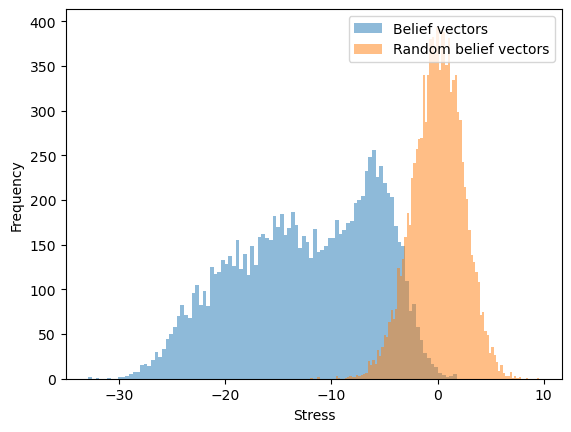

In [8]:
""" Okay, and now we calculate the stress of the belief vectors """

correlation_matrix_noDiag = correlation_matrix_partial - np.eye(correlation_matrix_partial.shape[0])
stress_vec = []
stress_vec = [stress(belief_vectors[i,:], correlation_matrix_noDiag) for i in range(belief_vectors.shape[0])]

""" We can also compare it to a random set of belief vectors """

# Generate K random belief vectors
random_belief_vectors = np.random.choice([-1, 0, 1], size=(len(stress_vec), len(variables_list)))
alt_belief_vectors = np.random.rand(len(stress_vec), len(variables_list))*2 - 1
alt_stress_vec = [stress(vector, correlation_matrix_noDiag) for vector in random_belief_vectors]

""" We can also compare the stress vectors of republican and democrat belief vectors """

from triads import count_triads
print(count_triads(correlation_matrix_partial))

import matplotlib.pyplot as plt
plt.hist(stress_vec, bins=100, alpha=0.5, label='Belief vectors', density=False)
plt.hist(alt_stress_vec, bins=100, alpha=0.5, label='Random belief vectors')
plt.legend(loc='upper right')
plt.xlabel('Stress')
plt.ylabel('Frequency')
plt.show()


In [9]:
""" And the modal belief vector """
from scipy.stats import mode
# index = mode(np.argmax(belief_vectors, axis=1)).mode[0]
import random as rd
index = rd.randint(0, belief_vectors.shape[0])


stress_dict, total_stress = stress_decomposition(belief_vectors[index], correlation_matrix_noDiag, variables_list)



print("Total Stress:", total_stress)
# print("Stress Contributions by Belief Pairs:")
# for pair, contribution in stress_dict.items():
#     if abs(contribution) > 0.01:
#         print(f"{pair}: {contribution}")


plot_stress_heatmap(stress_dict, variables_list)


NameError: name 'stress_decomposition' is not defined

In [ ]:
""" Now we can print out the belief vectors in an interpretable way """

""" We can look at the least stressed belief vector """
index = np.argmin(stress_vec)
print("Least stressed belief vector: ")
print(stress(belief_vectors[index], correlation_matrix_noDiag))
print(interpret_belief_vector(belief_vectors[index], variables_list))

""" And the most stressed belief vector """
index = np.argmax(stress_vec)
print("\nMost stressed belief vector: ")
print(stress(belief_vectors[index], correlation_matrix_noDiag))
print(interpret_belief_vector(belief_vectors[index], variables_list))

""" And a median stressed belief vector """
index = np.argsort(stress_vec)[len(stress_vec)//2]
print("\nMedian stressed belief vector: ")
print(stress(belief_vectors[index], correlation_matrix_noDiag))
print(interpret_belief_vector(belief_vectors[index], variables_list))

""" And the modal belief vector """
from scipy.stats import mode
index = mode(np.argmax(belief_vectors, axis=1)).mode[0]
print("\nModal belief vector: ")
print(stress(belief_vectors[index], correlation_matrix_noDiag))
print(interpret_belief_vector(belief_vectors[index], variables_list))

_, max_term = stress_slow(belief_vectors[index], correlation_matrix_noDiag)
print(max_term)





Least stressed belief vector: 
-29.499520882783926
PARTYID = 0.9999999999666667. Leans towards the Republican party.
POLVIEWS = 0.9999999999666667. Is conservative.
NATSPAC = -5.000000413701855e-11. Believes the government is spending too little on the space exploration program.
NATENVIR = 0.9999999999. Believes the government is spending too much on improving and protecting the environment.
NATHEAL = 0.9999999999. Believes the government is spending too much on improving and protecting the nation's health.
NATCITY = 0.9999999999. Believes the government is spending too much on solving the problems of big cities.
NATCRIME = 0.9999999999. Believes the government is spending too much on halting the rising crime rate.
NATDRUG = 0.9999999999. Believes the government is spending too much on dealing with drug addiction.
NATEDUC = 0.9999999999. Believes the government is spending too much on improving the nation's education system.
NATRACE = 0.9999999999. Believes the government is spending t

C:\Users\timbo\AppData\Local\Temp\ipykernel_20344\668281959.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  index = mode(np.argmax(belief_vectors, axis=1)).mode[0]


TypeError: stress_slow() missing 1 required positional argument: 'variable_list'